In [2]:
import json
file_name = "instruction-data.json"
with open(file_name,"r",encoding="utf-8") as file:
  data = json.load(file)
print(data)

[{'instruction': 'Evaluate the following phrase by transforming it into the spelling given.', 'input': 'freind --> friend', 'output': 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".'}, {'instruction': 'Edit the following sentence for grammar.', 'input': 'He go to the park every day.', 'output': 'He goes to the park every day.'}, {'instruction': 'Convert 45 kilometers to meters.', 'input': '', 'output': '45 kilometers is 45000 meters.'}, {'instruction': "Rewrite this sentence to start with 'Although': Despite the rain, they went for a walk.", 'input': '', 'output': 'Although it was raining, they went for a walk.'}, {'instruction': 'What are the first 10 square numbers?', 'input': '', 'output': '1, 4, 9, 16, 25, 36, 49, 64, 81, 100.'}, {'instruction': 'Suggest a more formal synonym for "happy."', 'input': '', 'output': 'A more formal synonym for "happy" is "content."'}, {'instruction': 'Translate the following sentence into French.', 'input': 'W

In [3]:
print("Number of entries",len(data))

Number of entries 1100


In [4]:
print("Example entry",data[50])

Example entry {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [5]:
print("Another example",data[999])

Another example {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


CONVERTING INSTRUCTIONS TO ALAPACA FORMAT

In [6]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [7]:
model_input = format_input(data[50])
desired_response = f"\n\n###Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

###Response:
The correct spelling is 'Occasion.'


In [8]:
model_input = format_input(data[999])
desired_response = f"\n\n###Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

###Response:
An antonym of 'complicated' is 'simple'.


SPLITTING DATASET INTO TRAIN-TEST-VALIDATION  

In [9]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion: train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length",len(train_data))
print("Validation set length",len(val_data))
print("Test set length",len(test_data))

Training set length 935
Validation set length 55
Test set length 110


ORGANISING DATA INTO TRAINING BATCHES

In [10]:
import torch
import tiktoken
from torch.utils.data import Dataset
tokenizer = tiktoken.get_encoding("gpt2")




class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [11]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [12]:
inputs_1 = [0,1,2,3,4]
inputs_2 = [5,6]
inputs_3 = [7,8,9]

batch = (inputs_1, inputs_2, inputs_3)
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


CREATE TARGET TOKEN IDS FOR INPUTS

In [13]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []
    targets_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_lst.append(inputs)
        targets_lst.append(targets)


    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor , targets_tensor

In [14]:
inputs_1 = [0,1,2,3,4]
inputs_2 = [5,6]
inputs_3 = [7,8,9]

batch = (inputs_1, inputs_2, inputs_3)
inputs , targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


REPLACING PADDING TOKENS WITH PLACEHOLDERS.

In [15]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index = -100,
    allowed_max_length = None,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []
    targets_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
          targets[indices[1:]] = ignore_index

        if allowed_max_length is not None:
          inputs = inputs[:allowed_max_length]
          targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)


    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor , targets_tensor

In [16]:
inputs_1 = [0,1,2,3,4]
inputs_2 = [5,6]
inputs_3 = [7,8,9]

batch = (inputs_1, inputs_2, inputs_3)
inputs, targets = custom_collate_fn(batch)
print("Inputs tensor:")
print(inputs)
print("\nTargets tensor:")
print(targets)

Inputs tensor:
tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])

Targets tensor:
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


-100 why it doesn't make difference to the loss

In [17]:
logits_1 = torch.tensor([[-1.0,1.0],[-0.5,1.5]])
targets_1= torch.tensor([0,1])

loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [18]:
logits_2 = torch.tensor([[-1.0,1.0],[-0.5,1.5],[-0.5,1.5]])
targets_2= torch.tensor([0,1,1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [19]:
logits_3 = torch.tensor([[-1.0,1.0],[-0.5,1.5],[-0.5,1.5]]) # Adding the third example didnt make any diff in loss w.r.t logits_1  .ignore_index = -100 in pytorch.
targets_3= torch.tensor([0,1,-100])

loss_3 = torch.nn.functional.cross_entropy(logits_3, targets_3)
print(loss_3)

tensor(1.1269)


DATA LOADERS IN INSTRUCTION FINETUNING

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device",device)

Device cuda


In [21]:
from functools import partial
customized_collate_fn = partial(custom_collate_fn, device = device, allowed_max_length = 1023)

In [22]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [23]:
print("Train loader:")
for inputs, targets in train_loader:
  print("Inputs shape:", inputs.shape)
  print("Targets shape:", targets.shape)



Train loader:
Inputs shape: torch.Size([8, 61])
Targets shape: torch.Size([8, 61])
Inputs shape: torch.Size([8, 76])
Targets shape: torch.Size([8, 76])
Inputs shape: torch.Size([8, 73])
Targets shape: torch.Size([8, 73])
Inputs shape: torch.Size([8, 68])
Targets shape: torch.Size([8, 68])
Inputs shape: torch.Size([8, 65])
Targets shape: torch.Size([8, 65])
Inputs shape: torch.Size([8, 72])
Targets shape: torch.Size([8, 72])
Inputs shape: torch.Size([8, 80])
Targets shape: torch.Size([8, 80])
Inputs shape: torch.Size([8, 67])
Targets shape: torch.Size([8, 67])
Inputs shape: torch.Size([8, 62])
Targets shape: torch.Size([8, 62])
Inputs shape: torch.Size([8, 75])
Targets shape: torch.Size([8, 75])
Inputs shape: torch.Size([8, 62])
Targets shape: torch.Size([8, 62])
Inputs shape: torch.Size([8, 68])
Targets shape: torch.Size([8, 68])
Inputs shape: torch.Size([8, 67])
Targets shape: torch.Size([8, 67])
Inputs shape: torch.Size([8, 77])
Targets shape: torch.Size([8, 77])
Inputs shape: torch.

LOADING PRETRAINED WEIGHTS (TO SAVE COMPUTATION RESOURCES)
LOADING GPT-2 355M Parameters

In [24]:
from gpt_download3 import download_and_load_gpt2

BASE_CONFIG = {
    "vocab_size":50257,
    "context_length":1024,
    "drop_rate":0.0,
    "qkv_bias":True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim":768,"n_layers":12,"n_heads":12},
    "gpt2-medium (355M)": {"emb_dim":1024,"n_layers":24,"n_heads":16},
    "gpt2-large (774M)": {"emb_dim":1280,"n_layers":36,"n_heads":20},
    "gpt2-xl (1558M)": {"emb_dim":1600,"n_layers":48,"n_heads":25}
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
settings, params = download_and_load_gpt2(model_size="355M", models_dir="gpt2")


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 238kiB/s]
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.79MiB/s]
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verificat

GPT Model

In [25]:

import torch
import torch.nn as nn

class GPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

  def forward(self,in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits


class LayerNorm(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean = x.mean(dim=-1,keepdim=True)
    var = x.var(dim=-1, keepdim=True,unbiased=False)
    norm_x = (x-mean)/torch.sqrt(var+self.eps) # eps added to avoid divide by zero error while normalizing
    return self.scale * norm_x + self.shift


class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5 * x * (1+ torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*
                      (x + 0.044715 * torch.pow(x,3))))

class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layers = nn.Sequential(nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
                                GELU(),
                                nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]))

  def forward(self,x):
    return self.layers(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec


class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.attn = MultiHeadAttention(d_in = cfg["emb_dim"],
                                   d_out = cfg["emb_dim"],
                                   context_length = cfg["context_length"],
                                   num_heads = cfg["n_heads"],
                                   dropout = cfg["drop_rate"],
                                   qkv_bias = cfg["qkv_bias"])
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self,x):
    shortcut = x
    x = self.norm1(x)
    x = self.attn(x)
    x = self.drop_shortcut(x)
    x = shortcut + x

    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = shortcut + x
    return x

In [26]:
import numpy as np

def assign(left, right):
  if left.shape != right.shape:
    raise ValueError(f"Shape mismatch. Leff :{left.shape}, Right: {right.shape}")
  return torch.nn.Parameter(torch.tensor(right))


def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].attn.W_query.weight = assign(
            gpt.trf_blocks[b].attn.W_query.weight, q_w.T)
        gpt.trf_blocks[b].attn.W_key.weight = assign(
            gpt.trf_blocks[b].attn.W_key.weight, k_w.T)
        gpt.trf_blocks[b].attn.W_value.weight = assign(
            gpt.trf_blocks[b].attn.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].attn.W_query.bias = assign(
            gpt.trf_blocks[b].attn.W_query.bias, q_b)
        gpt.trf_blocks[b].attn.W_key.bias = assign(
            gpt.trf_blocks[b].attn.W_key.bias, k_b)
        gpt.trf_blocks[b].attn.W_value.bias = assign(
            gpt.trf_blocks[b].attn.W_value.bias, v_b)

        gpt.trf_blocks[b].attn.out_proj.weight = assign(
            gpt.trf_blocks[b].attn.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].attn.out_proj.bias = assign(
            gpt.trf_blocks[b].attn.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


In [27]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model,params)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear

Checking response before finetuning

In [28]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [29]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx


In [30]:

import tiktoken

def text_to_token_ids(text,tokenizer):
  encoded = tokenizer.encode(text,allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())


In [31]:
token_ids = generate(model = model, idx = text_to_token_ids(input_text,tokenizer),max_new_tokens = 35, context_size= BASE_CONFIG["context_length"],eos_id = 50256,)

generated_text = token_ids_to_text(token_ids,tokenizer)

In [32]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [33]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


CALCULATING LOSS

In [34]:
def calc_loss_batch(input_batch,target_batch,model,device):
  input_batch, target_batch = input_batch.to(device), target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0,1),target_batch.flatten())
  return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0
  if len(data_loader) ==0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches,len(data_loader))

  for i , (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch,target_batch, model, device)
      total_loss += loss.item()
    else:
      break
  return total_loss/ num_batches

def generate_text_simple(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    # Crop current context if it exceeds the supported context sixe
    # Ex if LLM Supports only 5 tokens, and the context size is 10 , then the last 5 tokens are used as context
    idx_cond = idx[:,-context_size:]

    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:,-1,:] # taking the last token predictions for each batch in logits tensor.
    probas = torch.softmax(logits, dim=-1) # Redundant but gives additional intuition
    idx_next = torch.argmax(probas, dim=-1, keepdim=True)
    idx = torch.cat((idx,idx_next),dim=1)
  return idx


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, eval_iter)
    val_loss = calc_loss_loader(val_loader, model, device, eval_iter)
  model.train()
  return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
  model.eval()
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context,tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_simple(model=model, idx = encoded, max_new_tokens=50, context_size = context_size)
  decoded_text = token_ids_to_text(token_ids,tokenizer)
  print(decoded_text.replace("\n"," "))
  model.train()

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
  train_losses, val_losses, track_tokens_seen = [],[],[]
  tokens_seen, global_step = 0, -1

  for epoch in range(num_epochs):
    model.train()

    for input_batch, target_batch in train_loader:
      optimizer.zero_grad() # Reset loss gradients from previous batch iteration
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      loss.backward()
      optimizer.step()
      tokens_seen += input_batch.numel()
      global_step += 1


      #Optional evaluation step
      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model, train_loader,val_loader, device, eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"Ep {epoch+1} (Step {global_step :06f}:)"
              f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
    generate_and_print_sample(
        model, tokenizer, device, start_context
    )
  return train_losses, val_losses, track_tokens_seen

In [35]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
  val_loss = calc_loss_loader(val_loader, model, device, num_batches = 5)

print("Training loss:", train_loss)
print("Validation loss",val_loss)

Training loss: 3.825909376144409
Validation loss 3.7619347095489504


In [36]:
import time

start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay = 0.1)

num_epochs = 1
train_losses, val_losses, tokens_seen = train_model_simple(model, train_loader, val_loader, optimizer, device,
                                                           num_epochs=num_epochs, eval_freq = 5, eval_iter = 5, start_context = format_input(val_data[0]), tokenizer = tokenizer)

end_time = time.time()
execution_time = (end_time - start_time) / 60
print(f"Execution time: {execution_time:.2f} minutes")

Ep 1 (Step 0.000000:)Train loss 2.637, Val loss 2.626
Ep 1 (Step 5.000000:)Train loss 1.174, Val loss 1.103
Ep 1 (Step 10.000000:)Train loss 0.872, Val loss 0.944
Ep 1 (Step 15.000000:)Train loss 0.857, Val loss 0.906
Ep 1 (Step 20.000000:)Train loss 0.776, Val loss 0.881
Ep 1 (Step 25.000000:)Train loss 0.754, Val loss 0.859
Ep 1 (Step 30.000000:)Train loss 0.799, Val loss 0.836
Ep 1 (Step 35.000000:)Train loss 0.714, Val loss 0.808
Ep 1 (Step 40.000000:)Train loss 0.672, Val loss 0.806
Ep 1 (Step 45.000000:)Train loss 0.633, Val loss 0.789
Ep 1 (Step 50.000000:)Train loss 0.663, Val loss 0.783
Ep 1 (Step 55.000000:)Train loss 0.760, Val loss 0.763
Ep 1 (Step 60.000000:)Train loss 0.719, Val loss 0.743
Ep 1 (Step 65.000000:)Train loss 0.653, Val loss 0.735
Ep 1 (Step 70.000000:)Train loss 0.533, Val loss 0.729
Ep 1 (Step 75.000000:)Train loss 0.568, Val loss 0.729
Ep 1 (Step 80.000000:)Train loss 0.604, Val loss 0.725
Ep 1 (Step 85.000000:)Train loss 0.509, Val loss 0.710
Ep 1 (Step 9

In [37]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

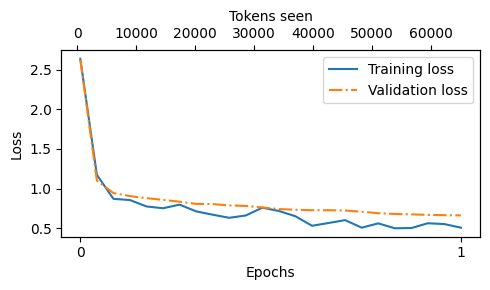

In [38]:
import torch
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

EXTRACTING AND SAVING RESPONSES

In [39]:
torch.manual_seed(123)

for entry in test_data[:3]:
  input_text_str = format_input(entry)
  token_ids = generate(model = model, idx = text_to_token_ids(input_text_str, tokenizer).to(device),max_new_tokens=256,context_size = BASE_CONFIG["context_length"],eos_id = 50256)
  generated_text = token_ids_to_text(token_ids, tokenizer)
  response_text = (generated_text[len(input_text_str):].replace("### Response:","").strip())
  print(f"Input text:\n{input_text_str}")
  print(f"\n Correct response:\n>> {entry['output']}")
  print(f"\n Model response:\n>> {response_text.strip()}")
  print("-" * 20)

Input text:
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

 Correct response:
>> The car is as fast as lightning.

 Model response:
>> The car is as fast as a bullet.
--------------------
Input text:
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

 Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

 Model response:
>> A thunderstorm is a type of cloud that typically forms in the atmosphere over a region of high pressure. It typically produces a strong wind that blows across the area, creating a dense, dense cloud.
--------------------
Input text:
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### I

METHOD3 : USING LLM TO EVALUATE LLM

In [1]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

NameError: name 'test_data' is not defined

In [41]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': "The author of 'Pride and Prejudice' is George Bernard Shaw."}


In [42]:
import re
file_name = f"gpt2-medium355M-sft.pth"
torch.save(model.state_dict(),file_name)
print(f"Model saved as {file_name}")

# Loading model
# model.load_state_dict(torch.load("model_name"))

Model saved as gpt2-medium355M-sft.pth


In [53]:
import psutil

def check_if_running(process_name):
  running = False
  for proc in psutil.process_iter(["name"]):
    if process_name in proc.info["name"]:
      running = True
      break
  return running
ollama_running = check_if_running("ollama")
if not ollama_running:
  raise RuntimeError("Ollama not running. Launch ollama before proceeding")
print("Ollama running:", check_if_running("ollama"))


RuntimeError: Ollama not running. Launch ollama before proceeding

In [49]:
import urllib.request

def query_model(
    prompt,
    model="llama3",
    url="http://localhost:11434/api/chat"
):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data

In [52]:
model = "llama3"
result = query_model("What do llamas eat?",model)
print(result)

URLError: <urlopen error [Errno 99] Cannot assign requested address>

In [56]:
test_data

[{'instruction': 'Rewrite the sentence using a simile.',
  'input': 'The car is very fast.',
  'output': 'The car is as fast as lightning.',
  'model_response': "The author of 'Pride and Prejudice' is George Bernard Shaw."},
 {'instruction': 'What type of cloud is typically associated with thunderstorms?',
  'input': '',
  'output': 'The type of cloud typically associated with thunderstorms is cumulonimbus.',
  'model_response': "The author of 'Pride and Prejudice' is George Bernard Shaw."},
 {'instruction': "Name the author of 'Pride and Prejudice'.",
  'input': '',
  'output': 'Jane Austen.',
  'model_response': "The author of 'Pride and Prejudice' is George Bernard Shaw."},
 {'instruction': 'What is the periodic symbol for chlorine?',
  'input': '',
  'output': 'The periodic symbol for chlorine is Cl.',
  'model_response': "The author of 'Pride and Prejudice' is George Bernard Shaw."},
 {'instruction': 'Correct the punctuation in the sentence.',
  'input': 'Its time to go home.',
  